In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.optimizers import Adam

In [3]:
env = gym.make('MountainCar-v0')
env

<TimeLimit<MountainCarEnv<MountainCar-v0>>>

In [4]:
env.reset()

array([-0.5021001,  0.       ], dtype=float32)

In [5]:
env.step(0)

(array([-0.50326127, -0.00116113], dtype=float32), -1.0, False, {})

In [6]:
env.action_space.n

3

In [7]:
env.reward_range

(-inf, inf)

In [8]:
env._max_episode_steps

200

In [9]:
for i in range(0,1000):
    a = np.random.randint(0,2)
    print(env.step(a))

(array([-0.5055748 , -0.00231356], dtype=float32), -1.0, False, {})
(array([-0.5080235 , -0.00244868], dtype=float32), -1.0, False, {})
(array([-0.51058894, -0.00256545], dtype=float32), -1.0, False, {})
(array([-0.51425195, -0.003663  ], dtype=float32), -1.0, False, {})
(array([-0.51898503, -0.00473309], dtype=float32), -1.0, False, {})
(array([-0.52475274, -0.00576769], dtype=float32), -1.0, False, {})
(array([-0.5315118 , -0.00675904], dtype=float32), -1.0, False, {})
(array([-0.53821146, -0.0066997 ], dtype=float32), -1.0, False, {})
(array([-0.5448016 , -0.00659014], dtype=float32), -1.0, False, {})
(array([-0.5522328 , -0.00743122], dtype=float32), -1.0, False, {})
(array([-0.55944955, -0.00721673], dtype=float32), -1.0, False, {})
(array([-0.56739795, -0.00794837], dtype=float32), -1.0, False, {})
(array([-0.57601875, -0.00862082], dtype=float32), -1.0, False, {})
(array([-0.584248  , -0.00822929], dtype=float32), -1.0, False, {})
(array([-0.59302497, -0.00877692], dtype=float32

In [10]:
class Actor:
    def __init__(self,state_shape,total_actions):
        self.input_shape = state_shape
        self.output_shape = total_actions
        self.model = self.theta_NN()
        self.step_size = 0.0001
        
    def step(self,state):
        action_probs,_ = self.predict_policy_actions(state) #generate probabilities from Actor N/W
        action = np.random.choice(self.output_shape, 1, p=action_probs.flatten())[0] #generate actions using 
                                                                        #the above probability distribution
        return action
    
    def theta_NN(self):
        
        inputs = keras.Input(shape=(self.input_shape,))
        x = layers.Dense(64, activation="relu")(inputs)
        x = layers.Dense(64, activation="relu")(x)
        outputs = layers.Dense(self.output_shape, activation="softmax")(x)
        model = keras.Model(inputs, outputs)
        model.compile(loss="mse", optimizer = Adam())

        return model
    
    def learn(self,samples):
        
        X = []
        y = []
        
        for state,action,delta in samples:
            
            state_f = self.preprocess(state)
            action_probs = self.model.predict(state_f).flatten()
            encoded_action = np.zeros(self.output_shape)
            encoded_action[action] = 1

            gradient = encoded_action - action_probs
            gradient_with_advantage = self.step_size * gradient * delta + action_probs
            gradient_with_advantage = gradient_with_advantage.reshape((1,self.output_shape))

            X.append([state_f])
            y.append(gradient_with_advantage)
            
        X = np.array(X)
        y = np.array(y)
        X = np.reshape(X,(X.shape[0],self.input_shape))
        y = np.reshape(y,(y.shape[0],self.output_shape))
        
        self.model.train_on_batch(X, y)

    def predict_policy_actions(self,state):
        state_f = self.preprocess(state)
        action_probabilities = self.model.predict([state_f],verbose=0)
        optimal_action = np.argmax(action_probabilities)
        
        return action_probabilities, optimal_action
    
    def preprocess(self,state):
        return np.reshape(state,(1,self.input_shape))
    
    def test_step(self,state):
        _,action = self.predict_policy_actions(state)
        return action

In [11]:
s = env.reset().shape[0]
a = env.action_space.n
actor = Actor(s,a,)
state = env.reset()
actor.step(state)

2022-11-22 21:43:11.386672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0

In [12]:
class Critic:
    def __init__(self,state_shape,total_actions):
        self.input_shape = state_shape
        self.model = self.w_NN()
    
    def w_NN(self):
        
        inputs = keras.Input(shape=(self.input_shape,))
        x = layers.Dense(64, activation="relu")(inputs)
        x = layers.Dense(64, activation="relu")(x)
        #x = layers.Dense(64, activation="relu")(x)
        outputs = layers.Dense(1, activation="linear")(x)
        model = keras.Model(inputs, outputs)
        model.compile(loss="mse", optimizer = Adam())
        
        return model
    
    def learn(self,samples):
        X = []
        y = []
        
        for state,action,delta in samples:
            state_f = self.preprocess(state)
            state_value = delta#np.array(delta)
            state_value_f = state_value.reshape((1,1))

            X.append([state_f])
            y.append(state_value_f)
            
        X = np.array(X)
        y = np.array(y)
        X = np.reshape(X,(X.shape[0],self.input_shape))
        y = np.reshape(y,(y.shape[0],1))
        
        self.model.train_on_batch(X, y)

    def preprocess(self,state):
        return np.reshape(state,(1,self.input_shape))
    
    def predict_VF_values(self,state):
        state_f = self.preprocess(state)
        state_value = self.model.predict([state_f],verbose=0).flatten()[0]
        return state_value

In [13]:
s = env.reset().shape[0]
a = env.action_space.n
critic = Critic(s,a,)
state = env.reset()
critic.predict_VF_values(state)

-0.0062923725

In [20]:
def main(no_of_episodes = 100,freq_time_steps=5):
    env = gym.make('MountainCar-v0')
    env.reset()
    state_shape = env.reset().shape[0]
    action_shape = env.action_space.n
    
    actor = Actor(state_shape,action_shape)
    critic = Critic(state_shape,action_shape)
    
    episodes = no_of_episodes
    discount_factor = 0.99
    
    overall_episode_rewards = np.array([])
    overall_time_steps = np.array([])
    samples  = []
    window = 10
    
    #train
    print("Training for {} episodes".format(episodes))
    for ep in range(1,episodes+1):
        
        state = env.reset()
        #env.render()
        
        episode_reward = 0
        time_step = 1
        train_freq_ts = freq_time_steps
        
        while True:
            
            action = actor.step(state)
            next_state, reward, done, info = env.step(action)
            
            reward = 100*((math.sin(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - 
                          (math.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]))
            
            if time_step > env._max_episode_steps:
                reward = -100
            
            #calculate delta
            state_value = critic.predict_VF_values(state)
            next_state_value = critic.predict_VF_values(next_state)
    
            if done:
                next_state_value = 0
            delta = reward + discount_factor * next_state_value - state_value
            samples.append((state,action,delta))
            
            #train every train_freq_ts timesteps
            if(time_step % train_freq_ts == 0):
                critic.learn(samples) #update weights/actor-model-params
                actor.learn(samples)  #update theta/actor-model-params
                samples = []

            state = next_state
            episode_reward += reward
            time_step += 1
            
            if done or time_step > env._max_episode_steps:
                break
            
        print("Episode:{}/{},return: {}".format(ep,episodes,episode_reward))
        overall_episode_rewards = np.append(overall_episode_rewards,episode_reward)
        
        if(ep > window+2):
            if np.mean(overall_episode_rewards[-window:]) > 100:
                print("==============>>>>> Converged at {} Episode <<<<<==============".format(ep))
                break

    plt.plot(overall_episode_rewards)
    plt.show()
    #plt.plot(overall_time_steps)

    #test
    print("Testing for 10 episodes")
    test_episode_rewards = np.array([])
    for ep in range(1,11):
        state = env.reset()
        test_rewards = 0
        time_step = 1
        
        while True:
            
            action = actor.test_step(state)
            next_state, reward, done, info = env.step(action)
            #reward = 100*((math.sin(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - 
            #              (math.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]))
            
            state = next_state
            test_rewards += reward
            time_step += 1
            
            
            if done or time_step > env._max_episode_steps:
                break
        print("Episode:{},return: {}".format(ep,test_rewards))
        test_episode_rewards = np.append(test_episode_rewards,test_rewards)
        
    plt.plot(test_episode_rewards)
    plt.show()

Training for 10 episodes
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step
Episode:1/10,return: -0.003250901813908443
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:2/10,return: 0.035763091489834475
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 11ms/step
Episode:3/10,return: 0.030243179168475
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 9ms/step
Episode:4/10,return: -0.0042614887982456075
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step
Episode:5/10,return: 0.000317533923332048
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 21ms/step
Episode:6/10,return: -0.0017411813512704412
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
Episode:7/10,return: 0.0011610433284690684
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Episode:8/10,return: 0.0061902872272680265
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Episode:9/10,return: 0.014716565695665866
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Episode:10/10,return: -0.004258521837657715


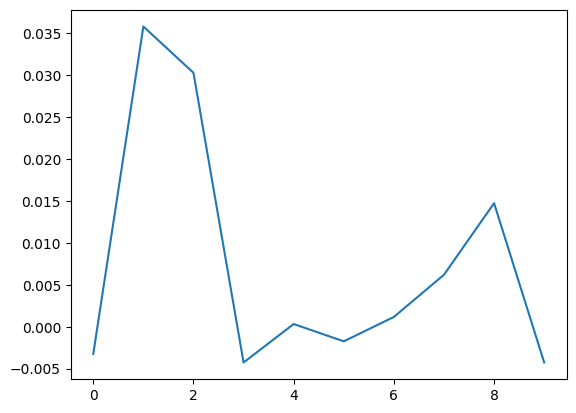

Testing for 10 episodes
Episode:1,return: -0.004800784861075423
Episode:2,return: -5.8993627249622274e-05
Episode:3,return: -2.9497127152725705e-06
Episode:4,return: -0.0028827201088864676
Episode:5,return: -0.000364690009840591
Episode:6,return: -0.0019766732793190765
Episode:7,return: -0.009446639215471503
Episode:8,return: -0.009597544622318111
Episode:9,return: -0.0002556842711695477
Episode:10,return: -0.0030276380423091987


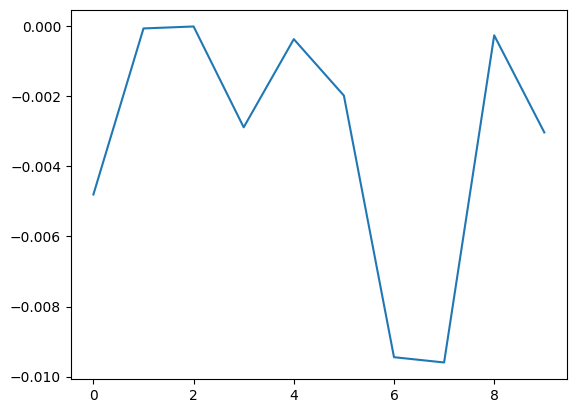

In [18]:
main(10,1)

Training for 100 episodes
1/1 [==============================] - 0s 35ms/step


2022-11-22 21:59:49.306483: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 53ms/step
Episode:1/100,return: -0.010894018903622165
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 43ms/step
Episode:2/100,return: -0.004099780393801433
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 24ms/step
Episode:3/100,return: -0.010405984029348413
1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 21ms/step
Episode:4/100,return: -0.0007792056724018667
1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 25ms/step
Episode:5/100,return: 0.1026197650380837
1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 62ms/step
Episode:6/100,return: 0.01313620688414901
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 100ms/step
Episode:7/100,return: 0.0027912671908659516
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step
Episode:8/100,return: 0.003809887505470221
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 52ms/step
Episode:9/100,return: 0.006472254434906203
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 28ms/step
Episode:10/100,return: -0.007793841934870338
1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 29ms/step
Episode:11/100,return: 0.00013660061473040608
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 27ms/step
Episode:12/100,return: -0.004710410661632001
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 48ms/step
Episode:13/100,return: 0.007689214196666233
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 42ms/step
Episode:14/100,return: 0.0007337512173808194
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 36ms/step
Episode:15/100,return: 0.013457429766644753
1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 94ms/step
Episode:16/100,return: -6.218837273232192e-05
1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 24ms/step


2022-11-22 22:20:56.583841: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 37ms/step
Episode:17/100,return: 0.03826663235931488
1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 102ms/step
Episode:18/100,return: -8.188037862498498e-05
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 27ms/step
Episode:19/100,return: 0.01144305022659762
1/1 [==============================] - 0s 50ms/step


2022-11-22 22:24:00.387256: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 55ms/step
Episode:20/100,return: 0.0061949096039375685
1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 24ms/step
Episode:21/100,return: 0.005002300957092061
1/1 [==============================] - 0s 32ms/step


2022-11-22 22:26:49.283724: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 58ms/step
Episode:22/100,return: 0.0018826780578002945
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 40ms/step
Episode:23/100,return: 0.005788336548981235
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 37ms/step
Episode:24/100,return: 0.021487240946167604
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 34ms/step
Episode:25/100,return: 0.041966937079882485
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 34ms/step
Episode:26/100,return: -0.0035897946592138887
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 69ms/step
Episode:27/100,return: 0.06727990385400384
1/1 [==============================] - 0s 41ms/step


2022-11-22 22:34:14.021808: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step
Episode:28/100,return: -0.0018457284871671812
1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 33ms/step
Episode:29/100,return: 0.007166609340384777
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 38ms/step
Episode:30/100,return: 0.016465956872863508
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 34ms/step
Episode:31/100,return: 0.01909318420108773
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step
Episode:32/100,return: 0.009421484038034304
1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 37ms/step


2022-11-22 22:42:26.369342: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 30ms/step
Episode:33/100,return: 0.006856754518752214
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 109ms/step
Episode:34/100,return: -0.003608443900926083
1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 108ms/step
Episode:35/100,return: -0.00026549772252506924
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
Episode:36/100,return: 0.008370209083948407
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 60ms/step
Episode:37/100,return: 0.06327217385960812
1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 87ms/step
Episode:38/100,return: 0.014496910224474744
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 49ms/step
Episode:39/100,return: 0.0029814406854946403
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


2022-11-22 22:51:18.223232: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 39ms/step
Episode:40/100,return: 0.017788368215588973
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 30ms/step
Episode:41/100,return: 0.004852429166250479
1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 32ms/step
Episode:42/100,return: -0.011061970828784478
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step
Episode:43/100,return: 0.03223016900426302
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 36ms/step
Episode:44/100,return: 0.022328505950329834
1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 73ms/step
Episode:45/100,return: 0.013632517598695552
1/1 [==============================] - 0s 47ms/step


2022-11-22 23:00:12.421068: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 29ms/step
Episode:46/100,return: 0.010262950349298645
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step
Episode:47/100,return: -0.009435885807981914
1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 57ms/step
Episode:48/100,return: 0.09703021171225126
1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 26ms/step
Episode:49/100,return: 0.008748438359161186
1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 21ms/step
Episode:50/100,return: 0.003330622364606942
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 56ms/step
Episode:51/100,return: 0.03184684956318898
1/1 [==============================] - 0s 63ms/step


2022-11-22 23:07:50.790957: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step
Episode:52/100,return: 0.042269698005511835
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


2022-11-22 23:10:03.512221: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 39ms/step
Episode:53/100,return: 0.003438154404117582
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 26ms/step
Episode:54/100,return: 0.07559336536468007
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step
Episode:55/100,return: 0.007525732204041041
1/1 [==============================] - 0s 49ms/step


2022-11-22 23:12:40.128233: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 57ms/step
Episode:56/100,return: 0.046053054826898386
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 22ms/step
Episode:57/100,return: 0.039026840502789956
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 20ms/step
Episode:58/100,return: 0.0350024324271897
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 32ms/step
Episode:59/100,return: 0.023020312623208694
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 53ms/step


2022-11-22 23:17:58.903942: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 34ms/step
Episode:60/100,return: 0.008533103776452814
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
Episode:61/100,return: 0.06283619410673733
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
Episode:62/100,return: -0.006283555305959011
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
Episode:63/100,return: 0.027174427409314382
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
Episode:64/100,return: 0.011197787766927104
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step
Episode:65/100,return: 0.010762526816106894
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:66/100,return: 0.023513279055672673
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:67/100,return: 0.06391919945595227
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 16ms/step
Episode:68/100,return: 0.030401525735645127
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:69/100,return: -0.0030153018820428066
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Episode:70/100,return: 0.010979959899428779
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step
Episode:71/100,return: 0.01437893506247537
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:72/100,return: 0.00786548742207657
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:73/100,return: -0.008350766808876533
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:74/100,return: 0.008203197180803454
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:75/100,return: 0.01694834161433756
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:76/100,return: 0.004881517323800056
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:77/100,return: 0.0021809713422834536
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:78/100,return: 0.015334557140399363
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:79/100,return: -6.711344198908828e-05
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:80/100,return: -0.00039697403121882226
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step
Episode:81/100,return: 0.010244828271463273
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:82/100,return: 0.0027460768665247288
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
Episode:83/100,return: 0.013427301557914561
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:84/100,return: 0.017658338881467235
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:85/100,return: -0.003952492775512097
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
Episode:86/100,return: 0.029972692776851623
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:87/100,return: 0.04210655401466362
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
Episode:88/100,return: 0.014682935110969162
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step
Episode:89/100,return: 0.004632510918508789
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
Episode:90/100,return: 0.0011268754540817022
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
Episode:91/100,return: 0.005494059840872563
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:92/100,return: 0.012018779531309056
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:93/100,return: 0.0027684595588261043
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:94/100,return: 0.05011151159931968
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:95/100,return: 0.009598002148715201
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step
Episode:96/100,return: 0.014902432977859438
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:97/100,return: -0.007299491395187582
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step
Episode:98/100,return: 0.01296743691635654
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:99/100,return: 0.04993225173842991
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step
Episode:100/100,return: -0.0004840538080047845


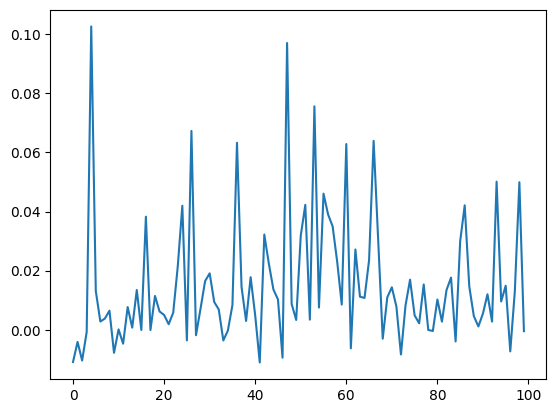

Testing for 10 episodes
Episode:1,return: -200.0
Episode:2,return: -200.0
Episode:3,return: -200.0
Episode:4,return: -200.0
Episode:5,return: -200.0
Episode:6,return: -200.0
Episode:7,return: -200.0
Episode:8,return: -200.0
Episode:9,return: -200.0
Episode:10,return: -200.0


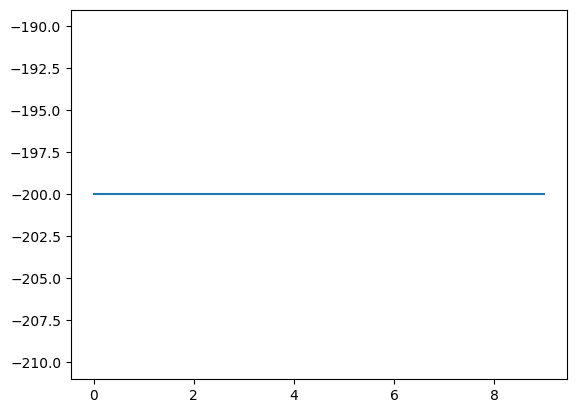

In [21]:
main(100,1)

In [ ]:
main(100,2)

Training for 100 episodes
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step
Episode:1/100,return: -0.003930005297624484
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:2/100,return: 0.017679010606603963
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:3/100,return: -0.008269037506683377
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:4/100,return: -0.003769067363563073
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:5/100,return: -0.00373369535633908
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:6/100,return: -0.0037804027568651578
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:7/100,return: 0.0044345227905407975
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
Episode:8/100,return: -0.001577285122658388
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step
Episode:9/100,return: 0.0032464863929132504
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:10/100,return: 0.0010764375118042062
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:11/100,return: 0.028893918143707426
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:12/100,return: 0.00029625406527955533
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step
Episode:13/100,return: 0.005861123883157227
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step
Episode:14/100,return: 0.006159110862523831
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:15/100,return: 0.009525199752151088
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:16/100,return: -0.0017058043721272613
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:17/100,return: 0.015543690573681063
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:18/100,return: 0.01479752084300525
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
Episode:19/100,return: 0.0326572092602522
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step
Episode:20/100,return: 0.03078373706115969
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step
Episode:21/100,return: 0.005294677399161115
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:22/100,return: 0.010946304758043693
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:23/100,return: -0.007090660809895002
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step
Episode:24/100,return: 0.01591956241855829
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
Episode:25/100,return: 0.012082010758856752


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:26/100,return: 0.009448091207593273
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step
Episode:27/100,return: 0.018708769052860896
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
Episode:28/100,return: 0.028167118736494027
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:29/100,return: -0.0016786734303111343
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:30/100,return: -0.005257783989721411
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:31/100,return: 0.014426082427567532
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step
Episode:32/100,return: 0.008681869810842242
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step
Episode:33/100,return: 0.004238310578793156
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Episode:34/100,return: 0.002455837508620431
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:35/100,return: 0.03666169336439179
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
Episode:36/100,return: 0.03128467928523472
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:37/100,return: 0.012710794099164483
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:38/100,return: 0.01813140345827295
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:39/100,return: 0.020447967413392415
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:40/100,return: 0.014884117709785793
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:41/100,return: 0.08346688123276488
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:42/100,return: 0.011608845283309313
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step
Episode:43/100,return: -9.163312386425287e-05
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:44/100,return: 0.046652957727980934
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
Episode:45/100,return: 0.002161655112070225
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:46/100,return: 0.018715384934542757
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step
Episode:47/100,return: -0.004252226606295912
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step
Episode:48/100,return: 0.009586698404541547
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 11ms/step
Episode:49/100,return: 0.018669810894945914
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:50/100,return: 2.276541067863097e-05


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:51/100,return: 0.0019366085746078902
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:52/100,return: -0.0004923388482333136
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - ETA: 0s

In [ ]:
main(300,1)

In [ ]:
main(300,2)

In [ ]:
main(500,3)

In [ ]:
main(1000,1)

In [ ]:
main(1000,3)

In [ ]:
main(3000,2)

In [ ]:
10 consecutive steps